#  Nibelungenlied and Völsunga saga

Not only do the medieval Germanic people share a common ancestor concerning their languages, but they also have a common hero celebrated in several stories (poems, sagas).

* **Völsunga saga** (*saga* written in Old Norse around the XIII century) 
* **Nibelungenlied** (poem written in Middle High German around the XII century)
* the heroic lays of the Poetic Edda (poems written in Old Norse like Grípisspá, Reginsmál, Fáfnismál, Sigrdrífumál)



We will study in what extent **Völsunga saga** and **Nibelungenlied** differ.

## 1. Loading texts

### 1.1 Völsunga saga

#### 1.1.1 Reading the text

Import the code to load the text.

In [1]:
import norsecorpus.reader as ncr

See which texts are available.

In [2]:
available_texts = ncr.get_available_texts()
print(available_texts.keys())

dict_keys(['volsunga.xml'])


Load the selected text.

In [3]:
volsunga_saga = ncr.read_tei_words(available_texts["volsunga.xml"])

Check what was loaded.

In [4]:
print(volsunga_saga[0][0][0])

['Hér', 'hefr', 'upp', 'ok', 'segir', 'frá', 'þeim', 'manni', ',', 'er', 'Sigi', 'er', 'nefndr', 'ok', 'kallaðr', ',', 'at', 'héti', 'sonr', 'Óðins', '.']


We can see that the imported has a structure. 

Medival copists wrote the text without structure [see the original manuscript](https://handrit.is/en/manuscript/view/AM02-0006). The text structure was made later by philologists.

Text => chapters. Chapter => paragraphs. Paragraph => sentences. Sentence => words. Word => character.


Text: `volsunga_saga`

Chapter: `volsunga_saga[i_chapter]`

Paragraph: `volsunga_saga[i_chapter][j_paragraph]`

Sentence: `volsunga_saga[i_chapter][j_paragraph][k_sentence]`

Word (or more precisely token): `volsunga_saga[i_chapter][j_paragraph][k_sentence][l_token]`

#### 1.1.2 Remove redundant information

Removal of stop words (words which appear in all kinds of texts)

In [5]:
from cltk.stop.old_norse.stops import STOPS_LIST

In [6]:
# {word for word in capital_words if word.lower() not in STOPS_LIST}

### 1.2 Loading Nieblungenlied (Augburg's corpus)

We import the functions to read the Nibelungenlied

In [7]:
import sig.nib_augsburg.nib_reader as nibaugr

`nibaugr.MAIN_LINKS` is the list of links to the different manuscription transcription of Nibelungenlied. The link is also the pointer to the stored text.

In [8]:
nibaugr.MAIN_LINKS[0]

'https://www.hs-augsburg.de/~harsch/germanica/Chronologie/12Jh/Nibelungen/nib_c_00.html'

`nibaugr.read_tei` extracts the content from a TEI-compliant XML file.

In [9]:
nibelungenlied_aug = nibaugr.read_tei(nibaugr.MAIN_LINKS[0])

(Explain why it is relevant to remove stop words from texts.) 

Less resourced languages often do not have many annotations and a stop word list is not always available. CLTK provides a class to extract stop words according to some criteria.

In [10]:
from cltk.stop import stop

In [11]:
mhg_stop_list = stop.BaseCorpusStoplist()
string_nibelungenlied_aug = [" ".join([" ".join(long_line) for long_line in chapter]) 
                                       for chapter in nibelungenlied_aug]
# mhg_stop_list.build_stoplist(string_nibelungenlied_aug)


## 2. Analysis of vocabulary

Which words are more likely associated to Sigurðr and to Siegfried?

* See POS tagging and lemmatization.
* Adjectives are more that are associated to the main character are more likely to describe him.

## 3. Tracking characters 



### 3.1 Sigurðr's relationships

#### 3.1.1 Proper nouns extraction

The main feature of proper nouns is that... their first character is a capital character. However, The first word of every sentence has also this feature. The idea is to keep the words with this feature without the ones which are after a punctuation marking a new sentence/sequence. We hope that we don't lose many proper nouns. 

In [12]:
capital_words = set()
sentence_delimiters = "?!.:``''\""
all_words = [word for chapter in volsunga_saga for para in chapter for sentence in para for word in sentence]
for i in range(1, len(all_words)):
    if all_words[i-1][-1] not in sentence_delimiters and all_words[i] and all_words[i][0].isupper():
        capital_words.add(all_words[i])

In [13]:
# capital_words

We got proper nouns in the tex with their different attested inflections.

Some are humans, some are dwarves, some are gods.

In [14]:
from collections import defaultdict


def common_prefix(s1, s2):
    """
    >>> len_common_prefix("bonjour", "bonsoir")
    "bon"
    """
    len_1 = len(s1)
    len_2 = len(s2)
    min_1_2 = min(len_1, len_2)
    i = 0
    while i < min_1_2:
        if s1[i] != s2[i]:
            break
        i += 1
    return i, s1[:i]

def find_paradigms(words):
    common_words = defaultdict(set)
    for i, w1 in enumerate(words):
        for j in range(i+1, len(words)):
            common_words[w1].add(w1)
            w2 = words[j]
            len_1_2, cw_1_2 = common_prefix(w1, w2)
            if len(w1) + 2 < len(w2) or len(w2) + 2 < len(w1):
                pass
            elif(len(w1) <= len_1_2*1.4 and len(w2) <= len_1_2*1.4): #  (len_1_2 < 2 and len(w1) < 4 and len(w2) < 4) or 
                common_words[cw_1_2].add(w1)
                common_words[cw_1_2].add(w2)
    common_words = {common_word: common_words[common_word] for common_word in common_words 
                    if common_word not in [co for cw in common_words if cw != common_word for co in common_words[cw]]}    
    return common_words


proper_nouns_paradigms = find_paradigms(list(capital_words))

volsunga_characters = {inflected_form: proper_noun_paradigm for proper_noun_paradigm in proper_nouns_paradigms 
                       for inflected_form in proper_nouns_paradigms[proper_noun_paradigm]}

# print(len(proper_nouns_paradigms))
# print(proper_nouns_paradigms)
# print(volsunga_characters)

#### 3.1.2 Ego graph of Sigurðr

In [15]:
# From "Applied Text Analysis with Python"
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [16]:
def one_of_them_in(l1, l2):
    for i in l1:
        if i in l2:
            return True
    return False

In [17]:
def cooccurrence_vol(text, characters):
    possible_pairs = list(itertools.combinations(list(characters.keys()), 2))
    cooccurring = dict.fromkeys(possible_pairs, 0)
    for chapter in text:
        for para in chapter:
            for sent in para:
                for pair in possible_pairs:
                    if one_of_them_in(characters[pair[0]], sent) and one_of_them_in(characters[pair[1]], sent):
#                         cooccurring[(characters[pair[0]], characters[pair[1]])] += 1
                        cooccurring[pair] += 1
    return cooccurring

In [18]:
def cooccurrence_nib_aug(text, characters):
    possible_pairs = list(itertools.combinations(list(characters.keys()), 2))
    cooccurring = dict.fromkeys(possible_pairs, 0)
    for chapter in text:
#         for long_line in chapter:
            for pair in possible_pairs:
                if one_of_them_in(characters[pair[0]], " ".join([" ".join(long_line) for long_line in chapter])) and one_of_them_in(characters[pair[1]], " ".join([" ".join(long_line) for long_line in chapter])):
#                         cooccurring[(characters[pair[0]], characters[pair[1]])] += 1
                    cooccurring[pair] += 1
    return cooccurring

Variants of Völsung.

In [19]:
proper_nouns_paradigms['Völsung']

{'Völsung', 'Völsunga', 'Völsungar', 'Völsungi', 'Völsungr', 'Völsungs'}

c:\users\clems\pycharmprojects\comparison_sigurdr_siegfried\venv\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


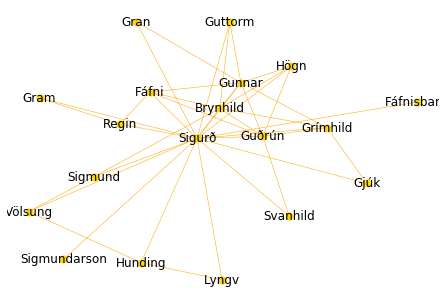

In [20]:
g_vol = nx.Graph()
g_vol.name = "Relationships of Sigurðr"
pairs = cooccurrence_vol(volsunga_saga, proper_nouns_paradigms)
for pair, weight in pairs.items():
    if weight > 1:
        g_vol.add_edge(pair[0], pair[1], weight=weight)
sigurdr = nx.ego_graph(g_vol, "Sigurð")
edges, weights = zip(*nx.get_edge_attributes(sigurdr, "weight").items())

pos = nx.spring_layout(sigurdr, k=0.5, iterations=40)
nx.draw(sigurdr, pos, node_color="gold", node_size=50, edgelist=edges, width=0.5, 
        edge_color="orange", with_labels=True, font_size=12)
plt.show()

### 3.2 Sigfried's relationships

#### 3.2.1 Proper nouns extraction

For this text, I extracted manually the places and the characters' names.

In [21]:
nib_names = nibaugr.read_names()

Variants of Brünhild in the manuscript C.

In [22]:
nib_names['Brünhild']

["Prvnh'",
 'Prvenhilde',
 'Privnhilde',
 'Prvnhilt',
 'Prvonhilde',
 'Prvnhilde',
 'Prunhilt',
 'Prunhilde']

#### 3.2.2 Ego graph of Siegfried

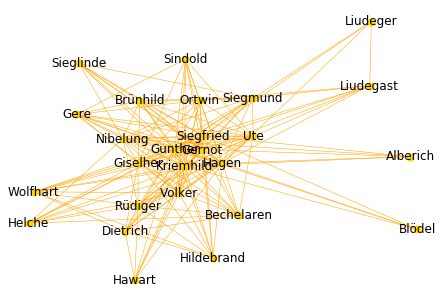

In [23]:
g_nib_aug = nx.Graph()
g_nib_aug.name = "Relationships of Siegfried"
pairs = cooccurrence_nib_aug(nibelungenlied_aug, nib_names)
for pair, weight in pairs.items():
    if weight > 2:
        g_nib_aug.add_edge(pair[0], pair[1], weight=weight)
        
siegfried = nx.ego_graph(g_nib_aug, "Siegfried")
edges, weights = zip(*nx.get_edge_attributes(siegfried, "weight").items())

pos = nx.spring_layout(siegfried, k=0.5, iterations=40)
nx.draw(siegfried, pos, node_color="gold", node_size=50, edgelist=edges, width=0.5, 
        edge_color="orange", with_labels=True, font_size=12)
plt.show()

## Conclusion

-----------------------------
By Clément Besnier, CLTK contributor ([www.clementbesnier.fr](https://www.clementbesnier.fr/) , [github](https://github.com/clemsciences), [twitter](https://twitter.com/clemsciences)).